In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from regression import KRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.kernel_ridge import KernelRidge

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [2]:
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
from utilities.sklearn_covr.pcovr import PCovR as PCovR2
from helpers import l_regr, l_kpcovr

# Functions

In [140]:
def df_to_class(df, df_type, n_classes, use_df_sums=True):
    """
        Make class predictions based on a decision function.
        Based on the sci-kit learn SVC prediction, see
        `sklearn.multiclass._ovr_decision_function` 
        (sci-kit learn licensed under BSD 3-Clause license)
        
        ---Arguments---
        df: decision function on which to make class predictions
        df_type: decision function type, 'ovo' or 'ovr'
        n_classes: number of integer classes
        use_df_sums: augment the 'ovo' vote counts with
            decision function values (useful for tie breaks)
            
        ---Returns---
        predicted_class: predicted integer class
    """
    
    predicted_class = None
    
    # Approximation to the number of classes, should be valid up to at least 1M
    #n_classes = int(np.sqrt(2*df.shape[-1])) + 1
    
    if df_type == 'ovo':
        vote_matrix = np.zeros((df.shape[0], n_classes))
        df_sum = np.zeros((df.shape[0], n_classes))

        # Predicted class determined by majority vote
        col_idx = 0
        for i in range(0, n_classes):
            for j in range(i + 1, n_classes):
                col_train = df[:, col_idx]
                vote_matrix[col_train > 0, i] += 1
                vote_matrix[col_train <= 0, j] += 1

                # Add value of decision function
                if use_df_sums:
                    df_sum[:, i] += df[:, col_idx]
                    df_sum[:, j] -= df[:, col_idx]

                col_idx += 1

        # sci-kit learn transformation from 'ovo' to 'ovr'
        if use_df_sums:
            transformed_df_sum = df_sum / (3 * (np.abs(df_sum) + 1))
            vote_matrix += transformed_df_sum

        predicted_class = np.argmax(vote_matrix, axis=1) + 1

    elif df_type == 'ovr':

        # Predicted class determined by largest value of the decision function
        predicted_class = np.argmax(df, axis=1) + 1
        
    else:
        print("Error: invalid decision function. Use 'ovo' or 'ovr'")
        
    return predicted_class

# Load data

In [23]:
# Load train and test set indices
train_idxs_deem = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs_deem = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_deem = train_idxs.size + test_idxs.size

In [24]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [25]:
# Load IZA cantons
iza_cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(iza_cantons == 4)[0][0]
iza_cantons = np.delete(iza_cantons, RWY)
n_iza = len(iza_cantons)

(array([169]),)


In [ ]:
# Make dummy DEEM cantons
deem_cantons = np.ones(n_deem, dtype=int) * 4

In [26]:
cutoff = 6.0

# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY);

array([[-0.00281038,  0.44229261,  0.12361648, ...,  0.00437123,
         0.00551277,  0.00056893],
       [-0.0028103 ,  0.44229261,  0.12361755, ...,  0.00437131,
         0.00551285,  0.00056887],
       [-0.00281031,  0.44229275,  0.1236168 , ...,  0.00437134,
         0.00551286,  0.0005689 ],
       ...,
       [-0.00281031,  0.44229311,  0.12361719, ...,  0.00437128,
         0.00551252,  0.00056898],
       [-0.00281059,  0.44229367,  0.12361391, ...,  0.00437097,
         0.00551275,  0.00056901],
       [-0.00281032,  0.44229303,  0.12361627, ...,  0.00437117,
         0.00551277,  0.00056894]])

# Set test and train sets for optimization and training

In [ ]:
n_subsets = 5

In [ ]:
# Select Deem subsets for training and testing
n_deem_train = 100 * n_subsets
n_deem_test = 100 * n_subsets

deem_idxs = np.arange(0, train_idxs_deem.size)
np.random.shuffle(deem_idxs)
deem_idxs = deem_idxs[0:n_deem_train+n_deem_test]

In [ ]:
# Select IZA subsets for training and testing
iza_idxs = np.arange(0, n_iza)
np.random.shuffle(iza_idxs)

In [ ]:
# Build the collection of soap vectors
# for the "master" kernel
deem = [deem_soaps[i] for i in deem_idxs]
iza = [iza_soaps[i] for i in iza_idxs]

In [ ]:
# Build "master" kernel between all DEEM and all IZA
K_master = build_kernel(iza+deem, iza+deem, kernel='gaussian', gamma=10.0)

# Build set of "master" canton labels
master_cantons = np.concatenate(iza_cantons[iza_idxs], deem_cantons[deem_idxs])

In [ ]:
# Split DEEM training into subsets for optimization and validation
deem_idxs_kernel = np.arange(0, deem_idxs.size)
np.random.shuffle(deem_idxs_kernel)

deem_idxs_train = np.split(deem_idxs[0:n_deem_train], n_subsets)
deem_idxs_test = np.split(deem_idxs[n_deem_train:], n_subsets)

In [ ]:
# Split IZA into subsets for optimization and validation
n_iza_train = int(n_iza / 2)
n_iza_test = n_iza - n_iza_train

iza_idxs_train = []
iza_idxs_test = []
for n in range(0, n_subsets):
    np.random.shuffle(iza_idxs)
    iza_idxs_train[n] = iza_idxs[0:n_iza_train]
    iza_idxs_test[n] = iza_idxs[n_iza_train:]

# Optimize SVM

In [ ]:
df_type = 'ovo'
C = np.logspace(-3, 3, 7)
class_accuracy_train = np.zeros((C.size, n_subsets))
class_accuracy_test = np.zeros((C.size, n_subsets))

In [120]:
for cdx, c in enumerate(C):    
    for n in range(0, n_subsets):
        
        # TODO: build kernels
        
        svc = SVC(kernel='precomputed', decision_function_shape=df_type, C=c)
        svc.fit(K_train_centered, Y_svm_train)
        
        class_accuracy_train[cdx, n] = svc.score(K_train_centered)
        class_accuracy_test[cdx, n] = svc.score(K_test_centered)

In [ ]:
C_opt = C[np.argmin(np.mean(class_accuracy_test, axis=1))]

# SVM on test and train sets

In [ ]:
# TODO: build kernel

svc = SVC(kernel='precomputed', decision_function_shape=df_type, C=C_opt)
svc.fit(K_train_centered, Y_svm_train)

Y_train = svc.decision_function(K_train_centered) 
Y_test = svc.decision_function(K_test_centered)

class_svm_train = svc.predict(K_train_centered)
class_svm_test = svc.predict(K_test_centered)

In [ ]:
Y_center = np.mean(Y_train, axis=0)
Y_scale = np.linalg.norm(Y_train - Y_center, axis=0) / np.sqrt(Y_train.shape[0] / Y_train.shape[1])

Y_train = (Y_train - Y_center) / Y_scale
Y_test = (Y_test - Y_center) / Y_scale

# Test KRR on the SVM decision function

In [125]:
krr = KernelRidge(alpha=1.0E-12, kernel='precomputed')
#krr = KRR(reg=1.0E-12)
krr.fit(K_train_centered, Y_train)
Yp_train = krr.predict(K_train_centered)
Yp_test = krr.predict(K_test_centered)

In [126]:
print(np.mean(np.abs(Yp_train - Y_train), axis=0))
print(np.mean(np.abs(Yp_test - Y_test), axis=0))

[1.06523872e-13 1.91694792e-14 1.77202335e-14 1.01445698e-13
 3.05236639e-14 5.39013806e-14]
[4.41498276e-13 9.93819668e-14 5.56937883e-14 9.05031050e-13
 8.41042042e-14 2.01437692e-13]


# Optimize KPCovR

In [127]:
# KPCovR parameters
alphas = np.linspace(0.0, 1.0, 11)
regs = np.logspace(-12, -1, 12)
n_kpcovr = 2

# Initialize matrices of losses
lrs_train = np.zeros((alphas.size, regs.size, n_cols))
lks_train = np.zeros((alphas.size, regs.size, n_cols))
lrs_test = np.zeros((alphas.size, regs.size, n_cols))
lks_test = np.zeros((alphas.size, regs.size, n_cols))
ltrs_train = np.zeros((alphas.size, regs.size))
ltks_train = np.zeros((alphas.size, regs.size))
ltrs_test = np.zeros((alphas.size, regs.size))
ltks_test = np.zeros((alphas.size, regs.size))

[223, 223, 222, 222, 222]
[array([ 410,  565,  815,  927,  382,  350,  598,   61,  679, 1014,   97,
        933,  966,  655,  825,  873,  869, 1084,  195,  230,   89,  136,
        197,  889,  455,  343, 1049,   50,  844,  947,  460,  615,  535,
        246,  513,  328,  926,  354,  876,  182, 1019,  977,  772, 1079,
        688,  713,  738,  141,  918,  901,  273, 1106,  211,  402,  113,
       1007,  648,  705, 1032,  998,  568,  882,  314,  891, 1074,  756,
        612,   25, 1078,  995, 1096,  355,  622,  357, 1022, 1012, 1031,
         58,  777,  188, 1056, 1095,   23,  322,   88,  813,  458,  718,
        965,   24, 1052,  852,  872,  757,  361,  643,  850, 1081,  946,
         35, 1063,    9,  950,  941,  900,  231, 1058,  169,  244,    7,
          0,  797,  152,  212,  590,  642,  105,  805,  704, 1043,  192,
        893,  963,  545,  853,   30,  481,  763,  215,  862,  303,  508,
        719,  952,  904,  632,  597,  697,   34,  736,  678,  339,  117,
        884,  692,  919,

In [128]:
# Determine optimal alpha and regularization via cross validation
for adx, alpha in enumerate(tqdm(alphas)):
    for rdx, r in enumerate(tqdm(regs, leave=False)):
        for n in tqdm(range(0, n_subsets), leave=False):
            # TODO: build kernels and Y
            
            # Center and scale for the fold
            y_center = np.mean(y_train, axis=0)
            y_train_centered = y_train - y_center
            y_test_centered = y_test - y_center
            y_scale = np.linalg.norm(y_train_centered, axis=0) \
                / np.sqrt(y_train_centered.shape[0] / y_train_centered.shape[1])
            y_train_centered = y_train_centered / y_scale
            y_test_centered = y_test_centered / y_scale
            
            # Even though we have auto-centering and auto-scaling,
            # center and scale here for the loss functions
            k_test_test_centered = center_kernel_oos_fast(k_test_test, k_test, k_train)
            k_test_centered = center_kernel_fast(k_test, K_ref=k_train)
            k_train_centered = center_kernel_fast(k_train)
            k_scale = np.trace(k_train_centered) / k_train_centered.shape[0]
            k_test_test_centered = k_test_test_centered/k_scale
            k_test_centered = k_test_centered/k_scale
            k_train_centered = k_train_centered/k_scale

            # KPCovR fit and predictions
            # Already scaled, so omit here to speed things up
            kpcovr = KPCovR2(mixing=alpha, n_components=n_kpcovr, kernel='precomputed', 
                             krr_params=dict(alpha=r))
            kpcovr.fit(k_train_centered, y_train_centered)
            
            t_train = kpcovr.transform(k_train_centered)
            yp_train_centered = kpcovr.predict(k_train_centered)
            t_test = kpcovr.transform(k_test_centered)
            yp_test_centered = kpcovr.predict(k_test_centered)
            
            #kpcovr = KPCovR(alpha=alpha, n_kpca=n_kpcovr, reg=r)
            #kpcovr.fit(k_train_centered, y_train_centered)

            #t_train = kpcovr.transform_K(k_train_centered)
            #yp_train_centered = kpcovr.transform_Y(k_train_centered)
            #t_test = kpcovr.transform_K(k_test_centered)
            #yp_test_centered = kpcovr.transform_Y(k_test_centered)

            # Collect regression and projection (KPCovR) losses for each canton
            lrs_test[adx, rdx, :] += l_regr(y_test_centered, yp_test_centered)
            lks_test[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                        k_test=k_test_centered,
                                        k_test_test=k_test_test_centered,
                                        t_train=t_train, t_test=t_test)

            lrs_train[adx, rdx, :] += l_regr(y_train_centered, yp_train_centered)
            lks_train[adx, rdx, :] += l_kpcovr(k_train=k_train_centered,
                                         t_train=t_train, t_test=t_test)

            # Total loss as sum of cantonwise losses
            ltrs_train[adx, rdx] += np.sum(lrs_train[adx, rdx, :])
            ltks_train[adx, rdx] += np.sum(lks_train[adx, rdx, :])

            ltrs_test[adx, rdx] += np.sum(lrs_test[adx, rdx, :])
            ltks_test[adx, rdx] += np.sum(lks_test[adx, rdx, :])
            
         
        # Average over the folds
        lrs_test[adx, rdx, :] /= k_folds
        lks_test[adx, rdx, :] /= k_folds

        ltrs_test[adx, rdx] /= k_folds
        ltks_test[adx, rdx] /= k_folds

        lrs_train[adx, rdx, :] /= k_folds
        lks_train[adx, rdx, :] /= k_folds

        ltrs_train[adx, rdx] /= k_folds
        ltks_train[adx, rdx] /= k_folds

In [130]:
# Extract optimal hyperparameters
max_idx_test = np.unravel_index(np.argmin(ltrs_test+ltks_test, axis=None), (ltrs_test+ltks_test).shape)
opt_alpha_idx = max_idx_test[0]
opt_reg_idx = max_idx_test[1]

opt_alpha = alphas[opt_alpha_idx]
opt_reg = regs[opt_reg_idx]

(9, 0)
0.9 1e-12


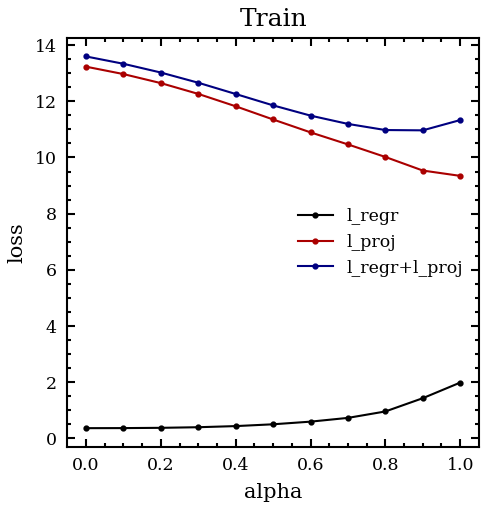

In [132]:
# Sum of projection and regression loss over all cantons for the train set
plt.plot(alphas, ltrs_train[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_train[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_train[:, opt_reg_idx]+ltks_train[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

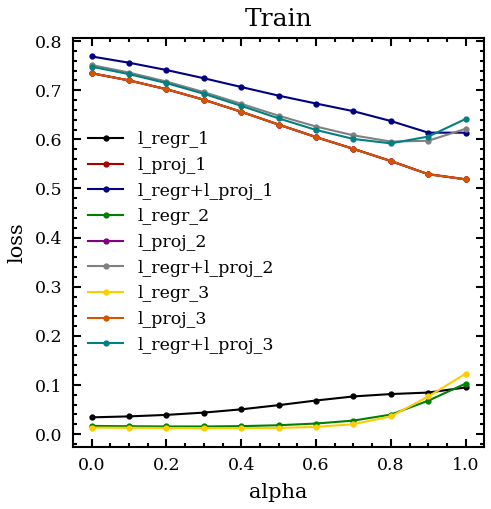

In [133]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_train[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_train[:, opt_reg_idx, i]+lks_train[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Train')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

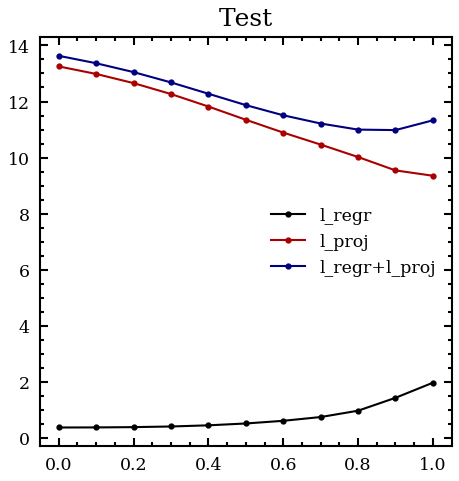

In [134]:
# Sum of projection and regression loss over all cantons for the test set
plt.plot(alphas, ltrs_test[:, opt_reg_idx], 'o-', label='l_regr')
plt.plot(alphas, ltks_test[:, opt_reg_idx], 'o-', label='l_proj')
plt.plot(alphas, ltrs_test[:, opt_reg_idx]+ltks_test[:, opt_reg_idx], 'o-', label='l_regr+l_proj')
plt.legend()
plt.title('Test')
plt.show()

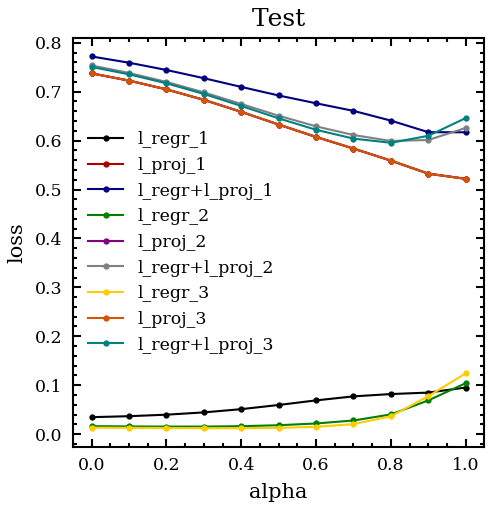

In [135]:
# Cantonwise losses for the train set
for i in range(0, 3):
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i], 'o-', label=f'l_regr_{i+1}')
    plt.plot(alphas, lks_test[:, opt_reg_idx, i], 'o-', label=f'l_proj_{i+1}')
    plt.plot(alphas, lrs_test[:, opt_reg_idx, i]+lks_test[:, opt_reg_idx, i], 'o-', label=f'l_regr+l_proj_{i+1}')

plt.legend()
plt.title('Test')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.show()

In [136]:
kpcovr = KPCovR2(mixing=opt_alpha, n_components=n_kpcovr, kernel='precomputed', krr_params=dict(alpha=opt_reg))
kpcovr.fit(K_train_centered, Y_train)
T_train = kpcovr.transform(K_train_centered)
Yp_train_centered = kpcovr.predict(K_train_centered) 
T_test = kpcovr.transform(K_test_centered) 
Yp_test_centered = kpcovr.predict(K_test_centered)

#kpcovr = KPCovR(alpha=opt_alpha, n_kpca=n_kpcovr, reg=opt_reg)
#T_train = kpcovr.transform_K(K_train_centered)
#Yp_train_centered = kpcovr.transform_Y(K_train_centered)
#T_test = kpcovr.transform_K(K_test_centered)
#Yp_test_centered = kpcovr.transform_Y(K_test_centered)

In [139]:
# Rescale to raw decision function
Yp_train = Yp_train_centered * Y_scale + Y_mean
Yp_test = Yp_test_centered * Y_scale + Y_mean

In [ ]:
# Predict classes based on KPCovRized decision functions
predicted_class_kpcovr_train = df_to_class(Yp_train, df_type, n_classes, use_df_sums=True)
predicted_class_kpcovr_test = df_to_class(Yp_test, df_type, n_classes, use_df_sums=True)

In [144]:
# Classification stats
print(classification_report(Y_svm_train, predicted_class_kpcovr_train))
print(classification_report(Y_svm_test, predicted_class_kpcovr_test))
print(confusion_matrix(Y_svm_train, predicted_class_kpcovr_train))
print(confusion_matrix(Y_svm_test, predicted_class_kpcovr_test))

0.9019784172661871
0.9083557951482479
              precision    recall  f1-score   support

           1       0.29      0.10      0.15        20
           2       0.38      0.25      0.30        60
           3       0.28      0.16      0.20        32
           4       0.94      0.98      0.96      1000

    accuracy                           0.90      1112
   macro avg       0.47      0.37      0.40      1112
weighted avg       0.88      0.90      0.89      1112

              precision    recall  f1-score   support

           1       0.33      0.20      0.25        15
           2       0.46      0.40      0.43        62
           3       0.29      0.11      0.16        36
           4       0.94      0.98      0.96      1000

    accuracy                           0.91      1113
   macro avg       0.51      0.42      0.45      1113
weighted avg       0.89      0.91      0.90      1113

[[  2   6   0  12]
 [  5  15   6  34]
 [  0   7   5  20]
 [  0  12   7 981]]
[[  3   2   0  

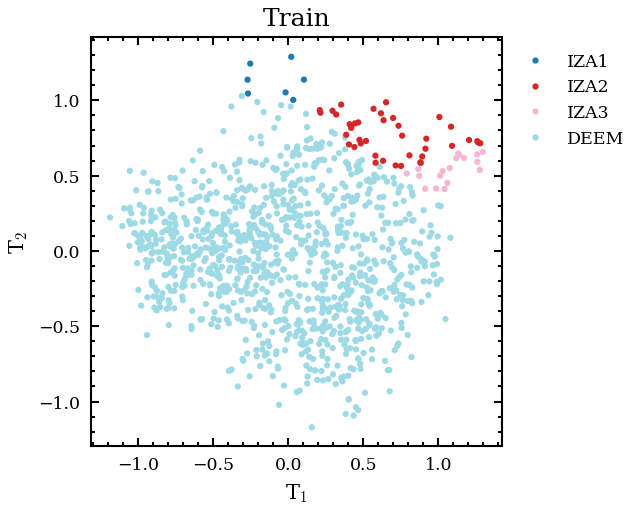

In [147]:
plt.scatter(T_train[n_iza_train:, 0], T_train[n_iza_train:, 1], 
            #c=Y_svm_train[n_iza_train:], cmap='tab20', vmin=1, vmax=4, zorder=2)
            c=class_kpcovr_train[n_iza_train:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_train[0:n_iza_train, 0], T_train[0:n_iza_train, 1], 
            #c=Y_svm_train[0:n_iza_train], cmap='tab20', vmin=1, vmax=4, zorder=3)
            c=class_kpcovr_train[0:n_iza_train], cmap='tab20', vmin=1, vmax=4, zorder=3)
#plt.scatter(T_train[:, 0], T_train[:, 1], c=Y_svm_train, cmap='tab20')
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Train')

plt.savefig('../Results/6.0/svm-kpcovr-test_train.png', bbox_inches='tight')

plt.show()

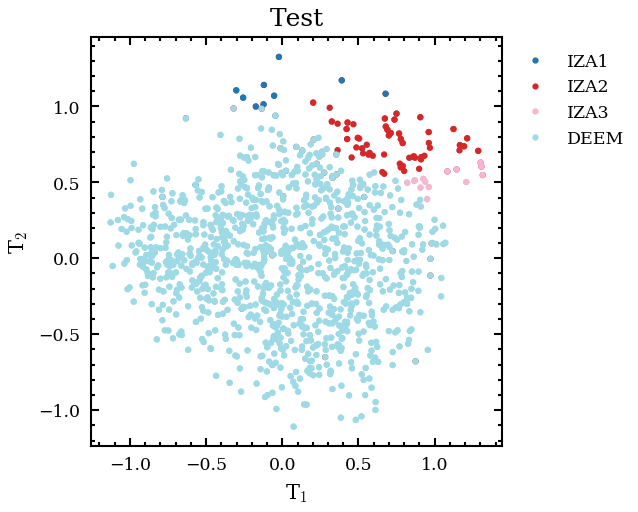

In [148]:
plt.scatter(T_test[n_iza_test:, 0], T_test[n_iza_test:, 1],
            #c=Y_svm_test[n_iza_test:], cmap='tab20', vmin=1, vmax=4, zorder=2)
            c=class_kpcovr_test[n_iza_test:], cmap='tab20', vmin=1, vmax=4, zorder=2)
plt.scatter(T_test[0:n_iza_test, 0], T_test[0:n_iza_test, 1],
            #c=Y_svm_test[0:n_iza_test], cmap='tab20', vmin=1, vmax=4, zorder=3)
            c=class_kpcovr_test[0:n_iza_test], cmap='tab20', vmin=1, vmax=4, zorder=3)
plt.scatter(T_test[:, 0], T_test[:, 1], c=Y_svm_test, cmap='tab20')
handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]
labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.xlabel(r'T$_1$')
plt.ylabel(r'T$_2$')
plt.title('Test')

plt.savefig('../Results/6.0/svm-kpcovr-test_test.png', bbox_inches='tight')

plt.show()